In [ ]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "xxxx"
os.environ["LANGCHAIN_PROJECT"] = "agent-book"

os.environ["OPENAI_API_KEY"] = "xxxx"

os.environ["TAVILY_API_KEY"] = "xxxx"

os.environ["COHERE_API_KEY"] = "xxxx"

In [2]:
!pip install numpy==1.26.4

In [3]:
import numpy as np

print(np.__version__)
assert np.__version__ == "1.26.4"

1.26.4


In [4]:
!pip install langchain-core==0.3.0 langchain-openai==0.2.0 \
    langchain-community==0.3.0 GitPython==3.1.43 \
    langchain-chroma==0.1.4 tavily-python==0.5.0 pydantic==2.10.6

## ドキュメントの読み込み

In [2]:
from langchain_community.document_loaders import GitLoader


def file_filter(file_path: str) -> bool:
    return file_path.endswith(".md")


loader = GitLoader(
    clone_url="https://github.com/open-mmlab/mmsegmentation",
    repo_path="./mmsegmentation",
    branch="main",
    file_filter=file_filter,
)

documents = loader.load()
print(len(documents))

172


## ドキュメントを適切なサイズにチャンク化

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
)

split_docs = text_splitter.split_documents(documents)
print(f"チャンク数: {len(split_docs)}")

チャンク数: 2420


## 文書をベクトル化

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
db = Chroma.from_documents(split_docs, embeddings)


## シンプルなRAG

In [5]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_template('''\
以下の文脈だけを踏まえて質問に回答してください。

文脈: """
{context}
"""

質問: {question}
''')

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

retriever = db.as_retriever()

chain = {
    "question": RunnablePassthrough(),
    "context": retriever,
} | prompt | model | StrOutputParser()

chain.invoke("mmsegmentationの概要を教えて")

'mmsegmentationは、画像セグメンテーションのためのオープンソースライブラリであり、さまざまなセグメンテーション手法を実装しています。このライブラリは、ユーザーが簡単にモデルを構築、トレーニング、評価できるように設計されており、特に深層学習を用いたセグメンテーションタスクに焦点を当てています。ドキュメントには、インストール手順や使用方法、FAQ、チュートリアルなどが含まれており、ユーザーがスムーズに利用を開始できるようサポートしています。'

## HyDE
LLMに仮説的な回答をさせ、それに類似したベクトルを抽出する

In [6]:
hypothetical_prompt = ChatPromptTemplate.from_template("""\
次の質問に回答する一文を書いてください。

質問: {question}
""")

hypothetical_chain = hypothetical_prompt | model | StrOutputParser()

In [7]:
hyde_rag_chain = {
    "question": RunnablePassthrough(),
    "context": hypothetical_chain | retriever,
} | prompt | model | StrOutputParser()

hyde_rag_chain.invoke("mmsegmentationの概要を教えて")

'MMSegmentationは、PyTorchに基づいたオープンソースのセマンティックセグメンテーションツールボックスです。OpenMMLabプロジェクトの一部であり、セマンティックセグメンテーション手法の統一された実装と評価のためのフレームワークを提供します。MMSegmentationは、以下の7つの主要部分で構成されています：\n\n1. **apis**: モデル推論のための高レベルAPIを提供。\n2. **structures**: セグメンテーションデータ構造`SegDataSample`を提供。\n3. **datasets**: セマンティックセグメンテーション用のさまざまなデータセットをサポート。\n   - **transforms**: 多くのデータ拡張変換を含む。\n4. **models**: セグメンターにとって最も重要な部分で、さまざまなセグメンターのコンポーネントを含む。\n   - **segmentors**: すべてのセグメントモデルクラスを定義。\n   - **data_preprocessors**: モデルの入力データを前処理するためのもの。\n   - **backbones**: 画像を特徴マップにマッピングするためのさまざまなバックボーンネットワークを含む。\n   - **necks**: セグメントヘッドとバックボーンネットワークを接続するためのさまざまなモデルの首部コンポーネントを含む。\n   - **decode_heads**: 特徴マップを入力として受け取り、セグメンテーション結果を予測するさまざまなセグメントヘッドを含む。\n   - **losses**: さまざまな損失関数を含む。\n\nMMSegmentationは、セマンティックセグメンテーションのための高品質な実装を提供し、さまざまなベンチマーク（例：Cityscapes、PASCAL VOC、ADE20K）で評価されます。'

### 複数の仮説的な回答を元にベクトル探索をする

In [8]:
from pydantic import BaseModel, Field


class QueryGenerationOutput(BaseModel):
    queries: list[str] = Field(..., description="検索クエリのリスト")


query_generation_prompt = ChatPromptTemplate.from_template("""\
質問に対してベクターデータベースから関連文書を検索するために、
3つの異なる検索クエリを生成してください。
距離ベースの類似性検索の限界を克服するために、
ユーザーの質問に対して複数の視点を提供することが目標です。

質問: {question}
""")

query_generation_chain = (
    query_generation_prompt
    | model.with_structured_output(QueryGenerationOutput)
    | (lambda x: x.queries)
)

In [9]:
multi_query_rag_chain = {
    "question": RunnablePassthrough(),
    "context": query_generation_chain | retriever.map(),
} | prompt | model | StrOutputParser()

multi_query_rag_chain.invoke("mmsegmentationの概要を教えて")

'MMSegmentationは、セマンティックセグメンテーションの手法を統一的に実装・評価するためのフレームワークを提供するツールボックスです。高品質なセマンティックセグメンテーション手法やデータセットの実装が含まれています。\n\nMMSegmentationは、以下の7つの主要な部分で構成されています：\n\n1. **apis**: モデル推論のための高レベルAPIを提供。\n2. **structures**: セグメンテーションデータ構造`SegDataSample`を提供。\n3. **datasets**: セマンティックセグメンテーション用のさまざまなデータセットをサポート。\n   - **transforms**: 有用なデータ拡張変換を多数含む。\n4. **models**: セグメンターにとって最も重要な部分で、セグメンターのさまざまなコンポーネントを含む。\n5. **engine**: モデルのトレーニングや評価を行うエンジン。\n6. **evaluation**: モデルの評価を行うための機能。\n7. **visualization**: セグメンテーション結果を視覚化するためのツール。\n\nMMSegmentationは、PyTorchに基づいたオープンソースのツールボックスであり、OpenMMLabプロジェクトの一部です。'

## 検索後の工夫

### RAG-Fusion
RRF(Reciprocal Rank Fusion)アルゴリズムを使って結果の並び替えをする

In [10]:
from langchain_core.documents import Document


def reciprocal_rank_fusion(
    retriever_outputs: list[list[Document]],
    k: int = 60,
) -> list[str]:
    # 各ドキュメントのコンテンツ (文字列) とそのスコアの対応を保持する辞書を準備
    content_score_mapping = {}

    # 検索クエリごとにループ
    for docs in retriever_outputs:
        # 検索結果のドキュメントごとにループ
        for rank, doc in enumerate(docs):
            content = doc.page_content

            # 初めて登場したコンテンツの場合はスコアを0で初期化
            if content not in content_score_mapping:
                content_score_mapping[content] = 0

            # (1 / (順位 + k)) のスコアを加算
            content_score_mapping[content] += 1 / (rank + k)

    # スコアの大きい順にソート
    ranked = sorted(content_score_mapping.items(), key=lambda x: x[1], reverse=True)  # noqa
    return [content for content, _ in ranked]

In [11]:
rag_fusion_chain = {
    "question": RunnablePassthrough(),
    "context": query_generation_chain | retriever.map() | reciprocal_rank_fusion,
} | prompt | model | StrOutputParser()

rag_fusion_chain.invoke("mmsegmentationの概要を教えて")

'MMSegmentationは、PyTorchに基づくオープンソースのセマンティックセグメンテーションツールボックスであり、OpenMMLabプロジェクトの一部です。このツールボックスは、セマンティックセグメンテーション手法の統一された実装と評価のためのフレームワークを提供し、人気のあるセマンティックセグメンテーション手法やデータセットの高品質な実装を含んでいます。\n\nMMSegmentationは、以下の7つの主要な部分で構成されています：\n\n1. **apis**: モデル推論のための高レベルAPIを提供。\n2. **structures**: セグメンテーションデータ構造`SegDataSample`を提供。\n3. **datasets**: セマンティックセグメンテーション用のさまざまなデータセットをサポート。\n   - **transforms**: 有用なデータ拡張変換を含む。\n4. **models**: セグメンターの最も重要な部分で、さまざまなセグメンターのコンポーネントを含む。\n5. **engine**: モデルのトレーニングや評価を行うエンジン。\n6. **evaluation**: モデルの評価を行うための機能。\n7. **visualization**: セグメンテーション結果を視覚化するためのツール。\n\nMMSegmentationは、さまざまなセマンティックセグメンテーションアルゴリズムを統合し、ベンチマークテストを行うための統一されたプラットフォームを提供します。また、最新のバージョン（v1.x）は、以前のバージョン（0.x）に比べて大幅な改善があり、より柔軟で機能豊富な体験を提供しています。'

### Cohere のリランクモデルを使用

In [13]:
!pip install langchain-cohere==0.3.0

INFO: pip is looking at multiple versions of langchain-core to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_core-0.3.65-py3-none-any.whl.metadata (5.8 kB)
  Using cached langchain_core-0.3.64-py3-none-any.whl.metadata (5.8 kB)
  Using cached langchain_core-0.3.63-py3-none-any.whl.metadata (5.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.1 MB/s eta 0:00:00
Using cached langchain_core-0.3.63-py3-none-any.whl (438 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 94.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core╸━━━━━━━━━━━━━━━━━━  6/11 [pandas]
    Found existing installation: langchain-core 0.3.0━━━━━━━━━  6/11 [pandas]
    Uninstalling langchain-core-0.3.0:m━━━━━━━━━━━━━━━━━━  6/11 [pandas]
      Successfully uninstalled langchain-core-0.3.0━━━━━━━━━━━  6/11 [pandas]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [langchain-cohere][langchain-experimental]


In [14]:
from typing import Any

from langchain_cohere import CohereRerank
from langchain_core.documents import Document


def rerank(inp: dict[str, Any], top_n: int = 3) -> list[Document]:
    question = inp["question"]
    documents = inp["documents"]

    cohere_reranker = CohereRerank(model="rerank-multilingual-v3.0", top_n=top_n)
    return cohere_reranker.compress_documents(documents=documents, query=question)


rerank_rag_chain = (
    {
        "question": RunnablePassthrough(),
        "documents": retriever,
    }
    | RunnablePassthrough.assign(context=rerank)
    | prompt | model | StrOutputParser()
)

rerank_rag_chain.invoke("mmsegmentationの概要を教えて")

'mmsegmentationは、画像セグメンテーションのためのオープンソースライブラリであり、深層学習を用いたセグメンテーションモデルの構築、トレーニング、評価をサポートします。このライブラリは、さまざまなセグメンテーションアルゴリズムを提供し、ユーザーが独自のデータセットを使用してモデルをトレーニングできるように設計されています。具体的には、設定ファイルの理解、データセットの準備、予訓練モデルを用いた推論、モデルのトレーニングとテストに関するチュートリアルが用意されています。詳細な情報は、公式ドキュメントで確認できます。'

## 複数の Retriever を使う工夫

### LLMによるルーティング

In [16]:
from langchain_community.retrievers import TavilySearchAPIRetriever

mmsegmentation_document_retriever = retriever.with_config(
    {"run_name": "mmsegmentation_document_retriever"}
)

web_retriever = TavilySearchAPIRetriever(k=3).with_config(
    {"run_name": "web_retriever"}
)

In [17]:
from enum import Enum


class Route(str, Enum):
    mmsegmentation_document = "mmsegmentation_document"
    web = "web"


class RouteOutput(BaseModel):
    route: Route


route_prompt = ChatPromptTemplate.from_template("""\
質問に回答するために適切なRetrieverを選択してください。

質問: {question}
""")

route_chain = (
    route_prompt
    | model.with_structured_output(RouteOutput)
    | (lambda x: x.route)
)

In [18]:
def routed_retriever(inp: dict[str, Any]) -> list[Document]:
    question = inp["question"]
    route = inp["route"]

    if route == Route.mmsegmentation_document:
        return mmsegmentation_document_retriever.invoke(question)
    elif route == Route.web:
        return web_retriever.invoke(question)

    raise ValueError(f"Unknown route: {route}")


route_rag_chain = (
    {
        "question": RunnablePassthrough(),
        "route": route_chain,
    }
    | RunnablePassthrough.assign(context=routed_retriever)
    | prompt | model | StrOutputParser()
)

In [19]:
route_rag_chain.invoke("mmsegmentationの概要を教えて")

'mmsegmentationは、画像セグメンテーションのためのオープンソースライブラリであり、深層学習を用いたセグメンテーション手法を提供します。このライブラリは、さまざまなセグメンテーションモデルをサポートしており、ユーザーが簡単にモデルを構築、トレーニング、評価できるように設計されています。具体的には、データセットの準備、モデルの設定、推論、トレーニングとテストに関するガイドラインが用意されており、ユーザーが効率的に作業を進められるようになっています。詳細なドキュメントも提供されており、英語と簡体中文の両方でアクセス可能です。'

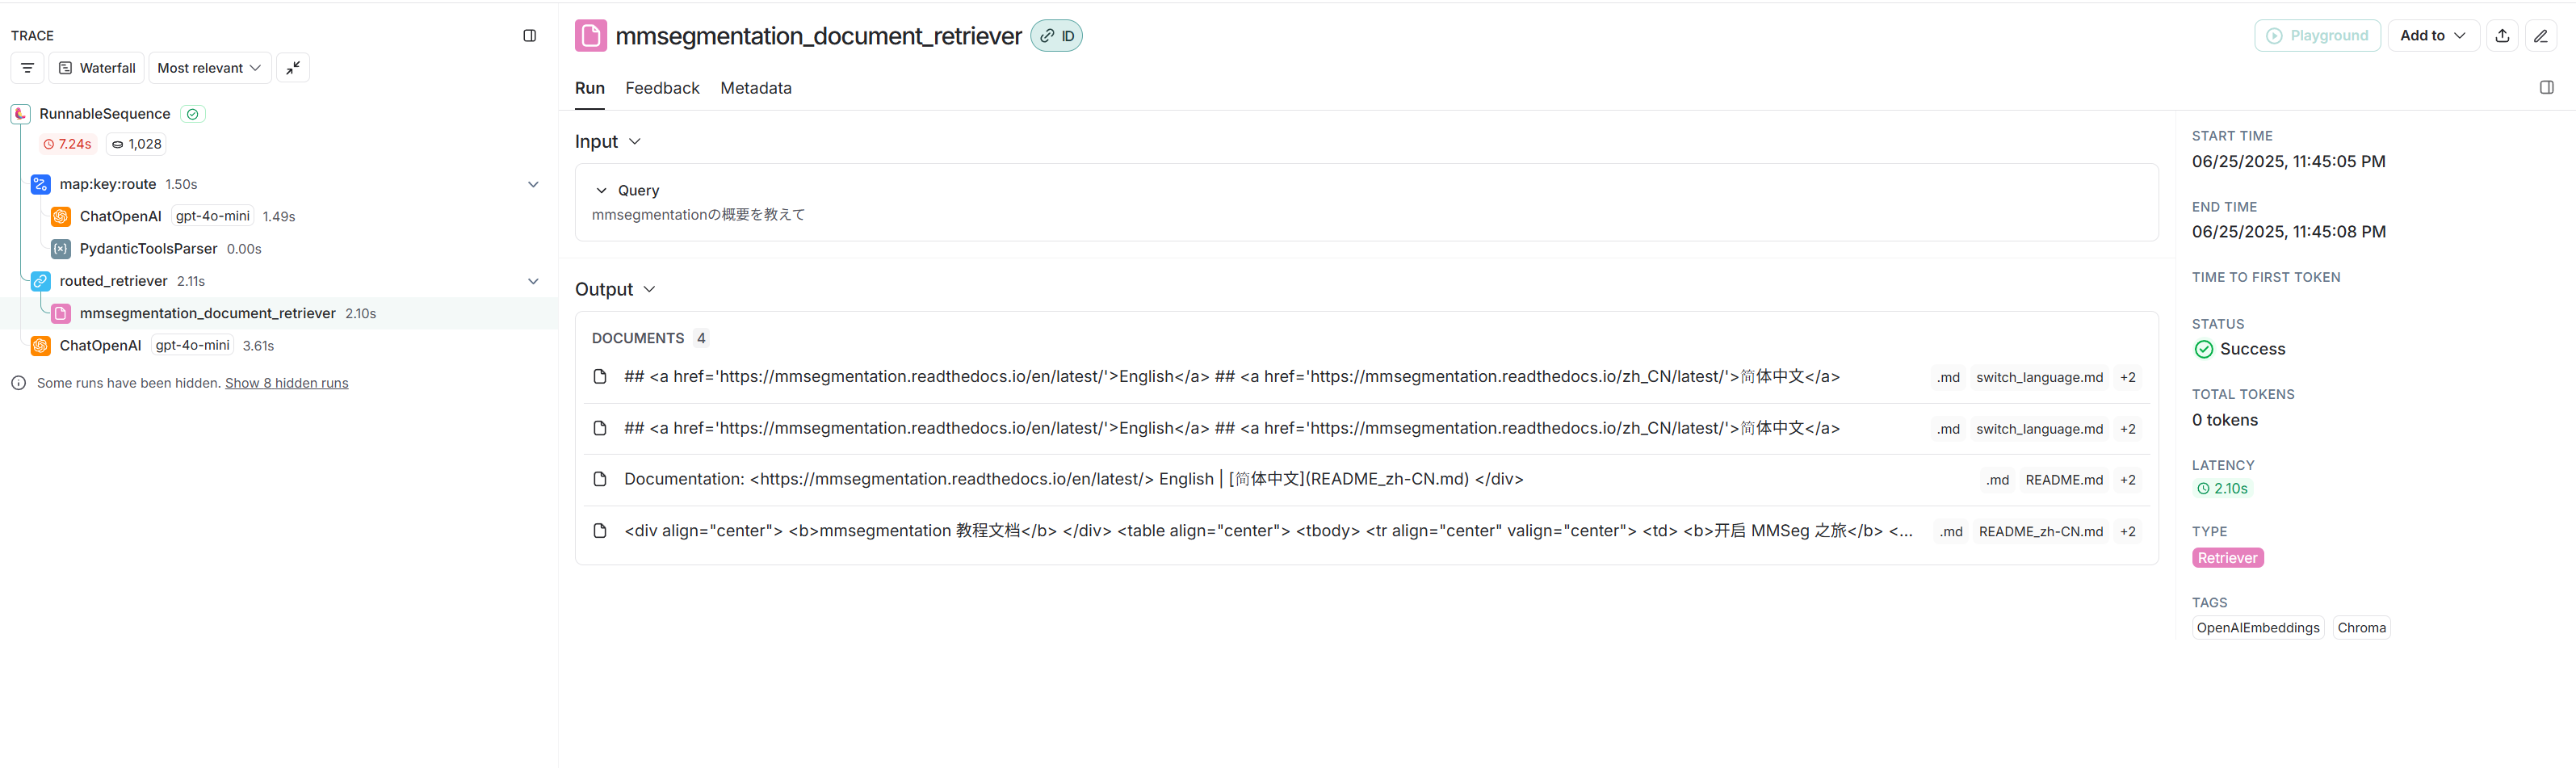

In [20]:
route_rag_chain.invoke("東京の今日の天気は？")

'東京の今日の天気は「曇のち雨」です。昼頃から所々で雨雲が湧き、夜は広く雨になる予報です。'

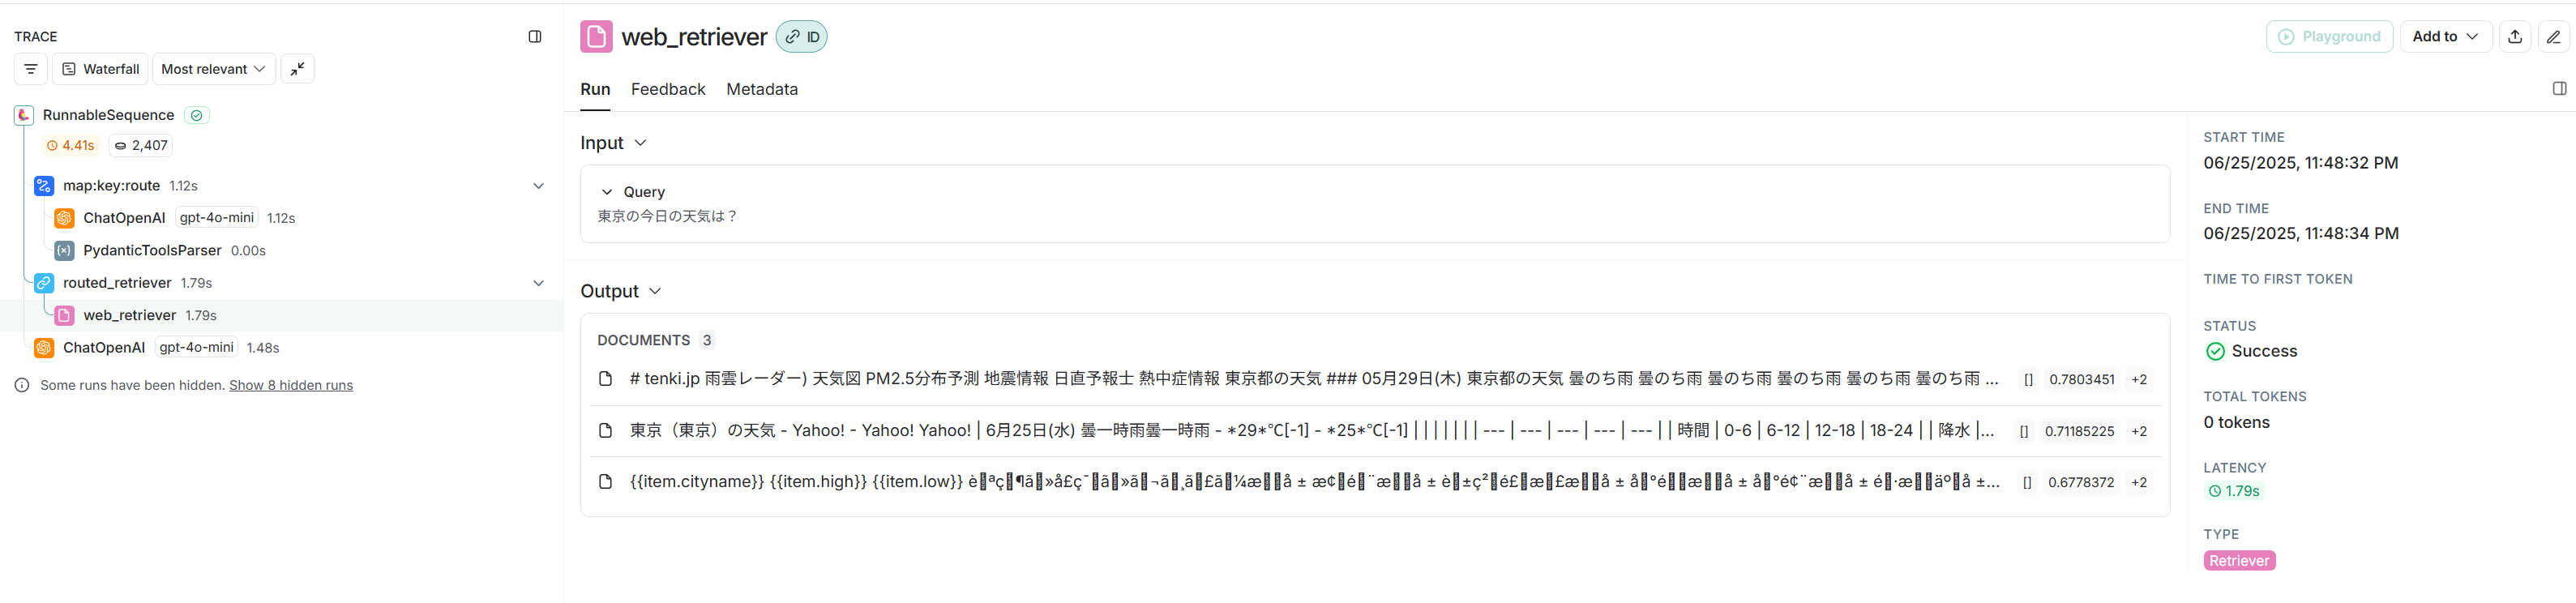

### ハイブリット検索の実装

In [21]:
!pip install rank-bm25==0.2.2

In [ ]:
from langchain_community.retrievers import BM25Retriever

# 埋め込みベクトルの類似度検索
chroma_retriever = retriever.with_config(
    {"run_name": "chroma_retriever"}
)

# 登場頻度をベースにテキストの類似度を算出
bm25_retriever = BM25Retriever.from_documents(documents).with_config(
    {"run_name": "bm25_retriever"}
)

In [23]:
from langchain_core.runnables import RunnableParallel

hybrid_retriever = (
    RunnableParallel({
        "chroma_documents": chroma_retriever,
        "bm25_documents": bm25_retriever,
    })
    | (lambda x: [x["chroma_documents"], x["bm25_documents"]])
    | reciprocal_rank_fusion
)

In [24]:
hybrid_rag_chain = (
    {
        "question": RunnablePassthrough(),
        "context": hybrid_retriever,
    }
    | prompt | model | StrOutputParser()
)

hybrid_rag_chain.invoke("mmsegmentationの概要を教えて")

'mmsegmentationは、セマンティックセグメンテーションのためのオープンソースフレームワークであり、さまざまなモデルやデータセットをサポートしています。このフレームワークは、特に医療画像処理やコンピュータビジョンのタスクにおいて、効率的で強力なセグメンテーション手法を提供します。\n\n主な特徴としては、以下の点が挙げられます：\n\n1. **多様なモデル**: mmsegmentationは、SegFormer、U-Net、Twinsなど、さまざまなセグメンテーションモデルを実装しています。これにより、ユーザーは特定のタスクに最適なモデルを選択できます。\n\n2. **データセットのサポート**: プロジェクトは、CRASS（Chest Radiograph Anatomical Structure Segmentation）などの特定のデータセットをサポートしており、データの準備や分割に関するスクリプトも提供しています。\n\n3. **トレーニングとテストの簡便さ**: ユーザーは、簡単なコマンドを使用してモデルのトレーニングやテストを行うことができ、設定ファイルを通じて柔軟にカスタマイズできます。\n\n4. **高いパフォーマンス**: 提供されるモデルは、さまざまなベンチマークデータセットで高い精度を達成しており、特に医療画像のセグメンテーションにおいて優れた結果を示しています。\n\n5. **ドキュメントとコミュニティ**: mmsegmentationは、詳細なドキュメントを提供しており、ユーザーがフレームワークを効果的に利用できるようにサポートしています。また、オープンソースであるため、コミュニティからの貢献も受け入れています。\n\nこのように、mmsegmentationは、セマンティックセグメンテーションの研究や実装において非常に有用なツールです。'